In [1]:
import sys
sys.path.append('../')

# Tools for Link Analysis: urlExpander
This notebook will walk through using links as data
1. What kind of link data does Twitter provide?
2. How to extract link data from Tweets
3. Processing data by expanding shortened URLs
4. Unsupervised techniques
5. Supervised techniques

Software for this tutorial is found in this `requirements.txt` file.

In [2]:
import os
import json
import glob
import itertools
from multiprocessing import Pool

from tqdm import tqdm
import pandas as pd
import urlexpander
from smappdragon import JsonCollection

In [3]:
data_directory = '/scratch/olympus/projects/mediascore/Data/json_standardized'
intermedia_directory = f'{data_directory}/processed_data/'
files = glob.glob(f'{data_directory}/*.json.bz2')
len(files)

1950

In [4]:
f = files[0]
f

'/scratch/olympus/projects/mediascore/Data/json_standardized/305620929__2018-04.json.bz2'

In [5]:
collect = JsonCollection(f, compression='bz2', throw_error=False, verbose=1)

In [6]:
collect

In [7]:
for row in collect.get_iterator():
    break

Link [here](https://bit.ly/tweet_anatomy_link)

In [8]:
#print(json.dumps(row, indent=2))

## How do we get the links?

In [9]:
?urlexpander.tweet_utils.get_link()

Signature: urlexpander.tweet_utils.get_link(tweet)
Docstring:
Returns a generator containing tweet metadata about media.

The metadata dict contains the following columns:

columns = {
  'link_domain' : 'the domain of the URL', 
  'link_url_long' : 'the URL (this can be short!)', 
  'link_url_short' : 'The t.co URL', 
  'tweet_created_at' : 'When the tweet was created', 
  'tweet_id' : 'The ID of the tweet', 
  'tweet_text' : 'The Full text of the tweet', 
  'user_id' : 'The Twitter ID of the tweeter'
}

:input tweet: a nested dictionary of a Tweet either from the streaming or search API.
:returns: a generator of dictionaries
File:      ~/smapprepos/urlExpander/urlexpander/core/tweet_utils.py
Type:      function


In [10]:
# returns a genrator, which is uninterpretable!
urlexpander.tweet_utils.get_link(row)

<generator object get_link at 0x2b73d84ac6d0>

In [11]:
# we can access the data by iterating through it.
for link_meta in urlexpander.tweet_utils.get_link(row):
    print(link_meta)

{'user_id': 305620929, 'tweet_id': 979414089654067200, 'tweet_created_at': 'Thu Mar 29 17:44:50 +0000 2018', 'tweet_text': None, 'link_url_long': 'https://twitter.com/thecyberwire/status/978772832317595650', 'link_domain': 'twitter.com', 'link_url_short': 'https://t.co/OSbgC94qVw'}


In [12]:
# to unwrap this we'll do this mess of cose
list(itertools.chain.from_iterable([urlexpander.tweet_utils.get_link(row)]))

[{'user_id': 305620929,
  'tweet_id': 979414089654067200,
  'tweet_created_at': 'Thu Mar 29 17:44:50 +0000 2018',
  'tweet_text': None,
  'link_url_long': 'https://twitter.com/thecyberwire/status/978772832317595650',
  'link_domain': 'twitter.com',
  'link_url_short': 'https://t.co/OSbgC94qVw'}]

## this is one way of doing this:

In [13]:
data = []
for f in tqdm(files[:2]):
    # read the json file into a generator
    collection = JsonCollection(f, compression='bz2', throw_error=False)
    
    # iterate through the json file, extract links, flatten the generator of links
    # into a list, and store into a Pandas dataframe
    df_ = pd.DataFrame(list(
            itertools.chain.from_iterable(
                [urlexpander.tweet_utils.get_link(t) 
                 for t in collection.get_iterator() 
                 if t]
            ))
    )
    df_['file'] = f
    data.extend(df_.to_dict(orient='records'))

100%|██████████| 2/2 [00:00<00:00,  2.23it/s]


## But with many files it is slow, so here's a faster paralellized way:

In [14]:
def read_file_extract_links(f):
    '''
    This function takes in a Tweet file that bzip2-compressed, 
    newline-deliminted json, and returns a list of dictionaries
    for link data.
    '''
    # read the json file into a generator
    collection = JsonCollection(f, compression='bz2', throw_error=False)
    
    # iterate through the json file, extract links, flatten the generator of links
    # into a list, and store into a Pandas dataframe
    df_ = pd.DataFrame(list(
            itertools.chain.from_iterable(
                [urlexpander.tweet_utils.get_link(t) 
                 for t in collection.get_iterator() 
                 if t]
            )))
    df_['file'] = f
    return df_.to_dict(orient='records')

In [15]:
data = []
with Pool(24) as pool:
    iterable = pool.imap_unordered(read_file_extract_links, files)
    for link_data in tqdm(iterable, total=len(files)):
        data.extend(link_data)
print(len(data))

100%|██████████| 1950/1950 [07:29<00:00,  4.33it/s]


1700150


In [16]:
data[2]

{'link_domain': 'facebook.com',
 'link_url_long': 'https://www.facebook.com/reprussell/posts/2009552275739610?comment_id=2009566382404866&notif_id=1521057100532804&notif_t=feed_comment&ref=notif',
 'link_url_short': 'https://t.co/wBvPlvpxyi',
 'tweet_created_at': 'Wed Mar 14 19:59:00 +0000 2018',
 'tweet_id': 974012037499154433,
 'tweet_text': None,
 'user_id': 2966758114,
 'file': '/scratch/olympus/projects/mediascore/Data/json_standardized/2966758114__2018-03.json.bz2'}

In [17]:
df_links = pd.DataFrame(data)

1700150

In [18]:
df_links.to_csv(os.path.join(intermedia_directory, 'links_raw.csv'), index=False)
df_links = pd.read_csv(os.path.join(intermedia_directory, 'links_raw.csv'))

In [251]:
links = df_links['link_url_long'].tolist()
links[-5:]

['http://goo.gl/kDUwP',
 'http://bit.ly/12clU3p',
 'http://nyti.ms/Z4rdlU',
 'http://goo.gl/LxkrY',
 'http://www.huffingtonpost.com/rep-diana-degette/reducing-gun-violence-mea_b_3018506.html']

In [258]:
url =  'http://www.huffingtonpost.com/rep-diana-degette/reducing-gun-violence-mea_b_3018506.html'
urlexpander.expand([url], verbose=2)

100%|██████████| 1/1 [00:00<00:00, 17.14it/s]

There are 1 links to unshorten


['https://www.huffingtonpost.com/rep-diana-degette/reducing-gun-violence-mea_b_3018506.html']

In [252]:
urlexpander.expand(links[-5])

'https://degette.house.gov/index.php?option=com_content&view=article&id=1260:congressional-lgbt-equality-caucus-praises-re-introduction-of-employment-non-discrimination-act&catid=76:press-releases-&Itemid=227'

In [253]:
urlexpander.expand(links[-5:])

['https://degette.house.gov/index.php?option=com_content&view=article&id=1260:congressional-lgbt-equality-caucus-praises-re-introduction-of-employment-non-discrimination-act&catid=76:press-releases-&Itemid=227',
 'http://www.rollcall.com/news/house_hydro_bill_tests_water_for_broad_energy_deals-224277-1.html',
 'https://www.nytimes.com/2013/04/18/opinion/a-senate-in-the-gun-lobbys-grip.html?smid=tw-share',
 'http://www.civiccenterconservancy.org/history-2012-nhl-designation_25.html',
 'http://huffingtonpost.com/__CLIENT_ERROR__']

## What's happening behind the scenes? 
['abc.com/123', 'bbc.co.uk/123', 'abc.com/123', 'bit.ly/cbc23']<br>
--> Remove duplicates<br>
 ['abc.com/123', 'bbc.co.uk/123', 'bit.ly/cbc23']<br>
--> Filter for shortened URLs<br>
['bit.ly/cbs23']<br>
--> unshorten<br>
[{'original_url': 'bit.ly/cbs23', 'resolved' : 'cspan.com/123'}]<br>
--> join back in<br>
['abc.com/123', 'bbc.co.uk/123', 'abc.com/123', 'cspan.com/123']<br>

In [22]:
?urlexpander.expand()

Signature: urlexpander.expand(links_to_unshorten, chunksize=1280, n_workers=1, cache_file=None, random_seed=303, verbose=0, filter_function=None, **kwargs)
Docstring:
Calls expand with multiple (``n_workers``) threads to unshorten a list of urls. Unshortens all urls by default, unless one sets a ``filter_function``.

:param links_to_unshorten: (list, str) either an idividual or list (str) of urls to unshorten
:param chunksize: (int) chunks links_to_unshorten, which makes computation quicker with larger inputs
:param n_workers: (int) how many threads
:param cache_file: (str) a path to a json file to read and write results in
:param random_seed: (int) initializes the random state for shuffling the input
:param verbose: (int) whether to print updates and errors. 0 is silent. 1 is progress bar. 2 is progress bar and errors.
:param filter_function: (func) a boolean used to filter url shorteners out
    

:returns: (list) a list of resolved urls
File:      ~/smapprepos/urlExpander/urlexpande

In [ ]:
cache_file = f'/{data_directory}/processed_data/cache.json'
resolved_urls = urlexpander.expand(links, 
#                                    filter_function=urlexpander.is_short,
                                   n_workers=100,
                                   chunksize=1280,
                                   cache_file=cache_file,
                                   verbose=1)

  0%|          | 0/381 [00:00<?, ?it/s]

There are 486837 links to unshorten


  4%|▍         | 17/381 [05:46<2:03:41, 20.39s/it]

In [51]:
len(resolved_urls)

1700150

In [52]:
df_links['link_resolved'] = resolved_urls
df_links['link_resolved_domain'] = df_links['link_resolved'].apply(urlexpander.get_domain)

In [254]:
df_links.to_csv(os.path.join(intermedia_directory, 'links_expanded_all.csv'), index=False)

## Analytics

In [ ]:
df_links = pd.read_csv(os.path.join(intermedia_directory, 'links_expanded_all.csv'))

In [54]:
df_links['link_resolved_domain'].value_counts().head(15)

twitter.com           255532
house.gov             199218
youtube.com            93986
facebook.com           90061
senate.gov             78645
washingtonpost.com     29886
instagram.com          28460
nytimes.com            25014
thehill.com            22925
politico.com           13488
foxnews.com            12045
cnn.com                11611
wsj.com                11289
twimg.com               9633
ow.ly                   9463
Name: link_resolved_domain, dtype: int64

In [55]:
exclude = ['youtube.com', 'twitter.com', 'fb.com', 
           'facebook.com', 'instagram.com', 'ow.ly', 
           'house.gov', 'senate.gov', 'usa.gov']

In [261]:
count_matrix = urlexpander.tweet_utils.count_matrix(
      df_links,
      user_col='user_id',
      domain_col='link_resolved_domain',
      min_freq=20,
).head(2)

## Machine Learning

In [56]:
pd.options.display.float_format = '{:,.0f}'.format

In [57]:
%matplotlib inline
import umap
import matplotlib.pyplot as plt

These files have the affiliation of each account.

In [58]:
meta_dir = '/scratch/olympus/projects/media_politician_list/google_sheet_archive'
meta = []
for f in glob.glob(f'{meta_dir}/*fulldata*.csv'):
    _df = pd.read_csv(f)
    _df = _df[~_df.twitter_id.isnull()]
    meta.extend(_df.to_dict(orient='records'))

In [59]:
df_meta = pd.DataFrame(meta)
df_meta.twitter_id = df_meta.twitter_id.astype(float, errors='ignore').astype(str)
df_links.user_id = df_links.user_id.astype(float, errors='ignore').astype(str)
look_up = df_meta[df_meta['twitter_id'].isin(df_links.user_id)].drop_duplicates(subset=['twitter_id'])[['twitter_id', 'affiliation']]
df_links_ = df_links[df_links.user_id.isin(look_up['twitter_id'])]

In [60]:
len(df_links_.user_id.unique()), len(look_up)

(971, 971)

## Unsupervised Learning
This will be an exploratory step, where we will try to visualze the dataset of counts of links shared by user. We will reduce the high-dimensional data (where each domain is one dimension) to two-dimensions for visualization using the [UMAP](https://umap-learn.readthedocs.io/en/latest/) algorithm (much like the populat [TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm).

In [193]:
def color(party):
    if party == 'Democrat':
        return 'blue' 
    elif party == 'Republican':
        return 'red'
    else:
        return 'gray'

def viz_umap_embed(count_matrix, title="Members of Congress Embedded by UMAP", threshold=5, **kwargs):
    '''
    Visualizes the count matrix in 2 dimensions using UMAP.
    '''
    if threshold:
        count_matrix = count_matrix[count_matrix.sum(axis=1) >= threshold]
    parties = look_up.set_index('twitter_id').loc[count_matrix.index].affiliation

    embedding = umap.UMAP(n_components=2, **kwargs).fit_transform(count_matrix.values)

    plt.figure(figsize=(14,8))
    ax = plt.scatter(x = embedding[:,0], 
                     y = embedding[:,1],
                     s = 100,
                     c = parties.apply(color),
                     alpha = .4)

    plt.title(title)
    plt.axis('off')
    plt.show()

In [278]:
count_matrix = urlexpander.tweet_utils.count_matrix(
      df_links_,
      user_col='user_id',
      domain_col='link_resolved_domain',
      min_freq=10,
      exclude_domain_list=exclude,
)

In [279]:
count_matrix.head(2)

,frc.org,thehill.com,iheart.com,c-span.org,news9.com,speaker.gov,foxnews.com,frcaction.org,koco.com,okcfox.com,...,brendalawrence.com,cityofsouthfield.com,voteearlyflorida.com,lattaforcongress.com,mullinforcongress.com,barbaracomstockforcongress.com,tomreedforcongress.com,sincomillas.com,garretgravesforcongress.com,about.com
user_id,,,,,,,,,,,,,,,,,,,,,
1004855106.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1009269193.0,0,12,0,16,0,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


/home/ly501/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype float32 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


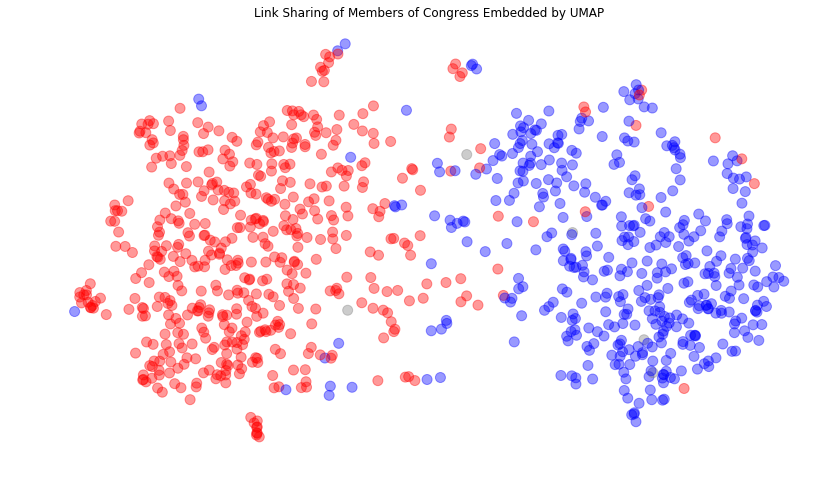

In [300]:
viz_umap_embed(count_matrix, 
               title="Link Sharing of Members of Congress Embedded by UMAP",
               threshold=5,
               # umap params
               n_neighbors=50,
               min_dist=0.1,
               metric='dice',
               random_state=303)

## Supervised Learning
In the unsupervised case, we already see Democrats and Republicans sectioned off. Here we will fit a [logistic regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model to predict whether a congress member is a democrat or a republican based on the `count_matrix` we just created.

In [202]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [203]:
# filter out independents, and accounts that sent less than one link!
dems_repubs = look_up[look_up.affiliation != 'Independent'].twitter_id
count_matrix_ = count_matrix[(count_matrix.index.isin(dems_repubs)) &
                             (count_matrix.sum(axis=1) >= 1)]
parties = look_up.set_index('twitter_id').loc[count_matrix_.index].affiliation

# create the training set
X, y = count_matrix_.values, parties
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=303, test_size=.1)
len(X_train), len(X_test) 

(867, 97)

In [277]:
logreg = LogisticRegression(penalty='l2', C=.75,
                            solver='liblinear',
                            random_state=303)
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

0.9587628865979382

## Evaluation

In [205]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [206]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[43  3]
 [ 1 50]]
Normalized confusion matrix
[[0.93 0.07]
 [0.02 0.98]]


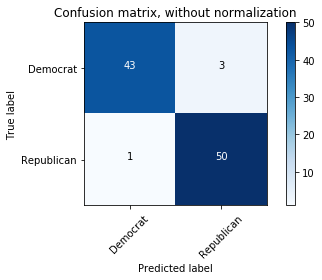

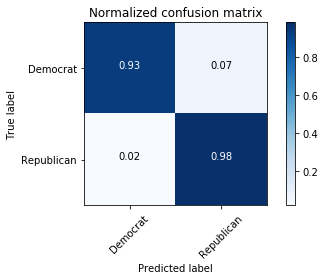

In [207]:
y_pred = logreg.predict(X_test)
class_names = logreg.classes_

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [132]:
# these are what we got wrong!
df_meta.set_index('twitter_id').loc[
    y_test[y_test != y_pred].index
][['twitter_name']]

,twitter_name
twitter_id,
555355209.0,NelsonForSenate
9.410800851211756e+17,SenDougJones
18061669.0,LisaMurkowski
322013313.0,LuisGutierrez
84129740.0,JoeLieberman


In [106]:
indep = look_up[look_up.affiliation == 'Independent'].twitter_id
count_matrix_indep_ = count_matrix[(count_matrix.index.isin(indep)) &
                                   (count_matrix.sum(axis=1) >= 2)]

In [155]:
df_ind = df_meta.set_index('twitter_id').loc[count_matrix_indep_.index][['twitter_name']]
df_ind['preds'] = logreg.predict(count_matrix_indep_)
df_ind

,twitter_name,preds
twitter_id,,
1068481578.0,SenAngusKing,Republican
216776631.0,BernieSanders,Democrat
2915095729.0,AkGovBillWalker,Republican
29442313.0,SenSanders,Democrat
3196634042.0,GovernorMapp,Republican


## News

In [ ]:
us_media = urlexpander.datasets.load_us_national_media_outlets()

In [ ]:
count_matrix_news = urlexpander.tweet_utils.count_matrix(
      df_links_,
      user_col='user_id',
      domain_col='link_resolved_domain',
      domain_list=us_media.tolist(),
)

In [ ]:
viz_umap_embed(count_matrix_news, 
               threshold=5,
               # umap args
               n_neighbors=50,
               min_dist=0.1,
               random_state=303,
               metric='dice',
               title='News Links Shared by Memebers of Congress Embedded by UMAP')

In [ ]:
count_matrix_news_ = count_matrix_news[(count_matrix_news.index.isin(dems_repubs)) &
                                       (count_matrix_news.sum(axis=1) >= 5)]
    
parties = look_up.set_index('twitter_id').loc[count_matrix_news_.index].affiliation
# is_dem = parties == 'Democrat'

X, y = count_matrix_news_.values, parties
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=303)
len(X_train), len(X_test) 

In [ ]:
logreg = LogisticRegression(penalty='l1', C=.7, multi_class='ovr')
logreg.fit(X_train, y_train)
logreg.score(X_test, y_test)

In [ ]:
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1)
forest.fit(X_train, y_train)
forest.score(X_test, y_test)